# DE SuperTrend Meo

## Import modules

In [1]:
#!pip install yfinance
#!pip install pandas_ta
#!pip install python-binance
try:
  import pandas_ta
except ModuleNotFoundError:
  !pip install pandas_ta
  pass

try:
  import binance
except ModuleNotFoundError:
  !pip install python-binance
  pass

try:
  import pymoo
except ModuleNotFoundError:
  !pip install pymoo
  pass
#Notes
#https://medium.datadriveninvestor.com/the-supertrend-implementing-screening-backtesting-in-python-70e8f88f383d
#https://twopirllc.github.io/pandas-ta/#overlap-33

# Don't forget to activate

In [2]:
#basestuffs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#timestuffs
from datetime import datetime, timedelta
import time

#financestuffs
import pandas_ta as ta
import math
import configparser
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
from binance.exceptions import BinanceAPIException

#query
import urllib.request
import json
#from google.colab import drive #unactived for dektop version

#
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.moead import MOEAD, ParallelMOEAD
from pymoo.factory import get_reference_directions, get_visualization
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize

## Parameters

In [3]:
# ############### PARAMETERS ############################## #
#crypto name
crypto ="SOL"

# TIMESPAN
atr_period = 10
atr_multiplier = 3
p = 9 # number of times atr should be added or removed from current price to obtain Target 
q = 25 # number of times atr should be added or removed from current price to obtain StopLoss

# FREQ
#fr_bnb = '1h'
fr_bnb = '1m'
fr_ml = 'H'
lm= 1440
ln_tf = "15min" #lunarcrush timeframe
interval = Client.KLINE_INTERVAL_1MINUTE #KLINE_INTERVAL_10MINUTE
limit = 7 * 5 # collect data for 7 * 5 days


################ API Instantiation
# instantiate parser to load ini file
config = configparser.ConfigParser()
config.read('CryptoBot/credentials.ini') #Set to TESTNET

api_k = config['general']['api_k']
api_sk = config['general']['api_sk']

# TESTNET instantiate parser to load ini file
t_config = configparser.ConfigParser()
t_config.read('CryptoBot/testnet_credentials.ini') #Set to TESTNET 1, for TESTNET 2 'goku_testnet_credentials.ini' 

t_api_k = t_config['general']['api_k']
t_api_sk = t_config['general']['api_sk']

## Functions

In [4]:
def get_hklines(symbol, interval, limit=7):
    ''' Function that collects data from Binance API using historical klines'''  
    try:
        #klines = client.get_historical_klines("BNBBTC", Client.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")        
        hklines = client.get_historical_klines(symbol, interval, str(limit) + " day ago")
        df = pd.DataFrame(hklines, columns=['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'Quote_asset_volume', 'Number_of_trades', 'Taker_buy_base_asset_volume', 'Taker_buy_quote_asset_volume', 'Ignore'])
    except BinanceAPIException as e:
        print(e)
        time.sleep(60*5)

    df['Datetime'] = df['Datetime'].astype('datetime64[ms]')
    df['Close_time'] = df['Close_time'].astype('datetime64[ms]')     

    df.set_index('Datetime', inplace=True)
    df.index = df.index + pd.Timedelta(hours=1) # Add 1 hours to convert UTC to UTC+1
    cols = df.columns[df.dtypes.eq('object')]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

    return df 

In [5]:
def conditions(df, p=6, q=6):
    '''Function that builds up conditions variables for BUY -- and maybe later for SELL'''
    #Make a copy of DF
    _df = df.copy()
    #add supatrend
    _df['st_value'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERT_7_3.0']
    _df['st_ind'] = _df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)['SUPERTd_7_3.0']

    # EMA200, ATR and StochRSI
    _df['ema200'] = _df.ta.ema(length=200)
    _df['atr'] = _df.ta.atr()
    _df['rsi_stoch_k'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3']
    _df['rsi_stoch_d'] = _df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3']
    _df.dropna(inplace=True)

    # Some conditions
    # <20 (oversold) value is 1, >80 value is 80 (overbought) # RSI-K used in the strat
    # rsi_sig_dif = 1 crossing downtrend 80 // crossing downtrend 20 (BUY SIG)
    # rsi_sig_dif = -1 crossing uptrend 80 (SELL SIG) // crossing uptrend 20
    _df['Buy'] = np.where((_df.Close > _df.ema200) & (_df['st_ind'] == 1) & (_df['rsi_stoch_k'] < 20), 1, 0)

    #comment 
    #(_df.Close - p * _df.atr  >= _df.Low.shift(-1)), 1, 0)
    # check if the trade would have worked // check if the lower price of next period is higher than our stoploss
    # Ratio p:q
    _df['Target'] = np.where(_df['Buy'] == 1, _df.Close + p * _df.atr, 0) 
    _df['Stop'] = np.where(_df['Buy'] == 1, _df.Close - q * _df.atr, 0) 

    return _df

In [6]:
def buys_sells_df(df):
    '''Builds a Buy and Sell dataframe to check profitability''' 
    ### Buy and Sell conditions
    buys, sells = [], []
    for i in range(len(df)):
        if df.Buy.iloc[i]:
            buys.append(df.iloc[i].name)

            for j in range(len(df) - i):
                if df.Target.iloc[i] < df.Close.iloc[i + j] or \
                df.Stop.iloc[i] > df.Close.iloc[i + j]:
                    sells.append(df.iloc[i + j].name)
                    break
    frame = pd.DataFrame([buys,sells]).T.dropna()
    frame.columns = ['Buys', 'Sells']
    return frame

In [7]:
def proft(x):
    '''Modded function that computes actuals buy and sells and compute profit vector'''
    '''Profit already uses conditions so no need to call it first!'''
    '''x is a list variable [p,q] containing p and q values'''
    dfo = conditions(df, x[0], x[1])
    a = buys_sells_df(dfo)[:1].append(buys_sells_df(dfo)[buys_sells_df(dfo).Buys > buys_sells_df(dfo).Sells.shift(1)])
    profit = (dfo.loc[a.Sells].Close.values - dfo.loc[a.Buys].Close.values) / dfo.loc[a.Buys].Close.values
    return profit

In [8]:
def proft_bt(_df,x):
    '''Modded function that computes actuals buy and sells and compute profit vector'''
    '''Profit already uses conditions so no need to call it first!'''
    '''x is a list variable [p,q] containing p and q values'''
    dfo = conditions(_df, x[0], x[1])
    a = buys_sells_df(dfo)[:1].append(buys_sells_df(dfo)[buys_sells_df(dfo).Buys > buys_sells_df(dfo).Sells.shift(1)])
    profit = (dfo.loc[a.Sells].Close.values - dfo.loc[a.Buys].Close.values) / dfo.loc[a.Buys].Close.values
    return profit

In [9]:
def plot_supatrend_stoch(df, x):
    '''Function that plot SupaTrend'''
    df = conditions(df, x[0], x[1])
    actualtrades = buys_sells_df(df)[:1].append(buys_sells_df(df)[buys_sells_df(df).Buys > buys_sells_df(df).Sells.shift(1)])
    # Pick needed variables from df
    st = df.ta.supertrend(period=atr_period, multiplier=atr_multiplier)
    strsi = pd.DataFrame({'STOCHRSIk_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSIk_14_14_1_3'], 'STOCHRSId_14_14_1_3' : df.ta.stochrsi(length = 14, k=1)['STOCHRSId_14_14_1_3'], "HI" : [80]*len(df.ta.stochrsi(length = 14, k=1).index), "LO" : [20]*len(df.ta.stochrsi(length = 14, k=1).index)})
    st["Close"] = df.Close
    st["ema200"] = df.ema200

    #figures
    fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,10))

    ax1.plot(st['SUPERTl_7_3.0'], color='green', label='SuperTrend LONG')
    ax1.plot(st['SUPERTs_7_3.0'], color='red', label='SuperTrend SHORT')
    ax1.plot(st['Close'], color='black', label='Price')
    ax1.plot(st[st.columns[-3:]]['ema200'], color='blue', label='ema200')
    ax1.set_title(crypto + " - " + fr_bnb)
    ax1.plot(actualtrades.Buys, df.loc[actualtrades.Buys]['Close'], '^', markersize=10, color='g')
    ax1.plot(actualtrades.Sells, df.loc[actualtrades.Sells]['Close'], '^', markersize=10, color='r')
    ax1.legend()

    ax2.plot(strsi['STOCHRSIk_14_14_1_3'], color ='red', label='stoch. RSI k')
    ax2.plot(strsi['STOCHRSId_14_14_1_3'], color='blue', label='stoch. RSI D')
    ax2.plot(strsi['HI'], color='black', linestyle="--")
    ax2.plot(strsi['LO'], color='black', linestyle="--")
    ax2.grid(True)
    ax2.legend()
    plt.show()

In [10]:
#from pymoo.core.problem import Problem
class MyProblem(ElementwiseProblem):
    '''Define class used to run the maxmin optimization'''    
    def __init__(self, **kwargs):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([1,1]),
                         xu=np.array([36,6]),
                         **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
        #f1 = - proft(x).mean()
        f1 = - proft(x).sum()
        f2 = proft(x).std()
        out["F"] = [f1, f2]

#problem = MyProblem()

## Load data

I will put for now data import on hold to speed up my work. Data will be imported from a csv:

In [11]:
# Connect to Binance Client
#client = Client(t_api_k, t_api_sk, testnet=True)
client = Client(api_k, api_sk)

In [12]:
# Load historical data from Binance
df_total = get_hklines(crypto+'USDT', interval, limit)
df_total.to_csv('df_total_sol.csv')

In [13]:
df_total = pd.read_csv('df_total_sol.csv', index_col='Datetime', parse_dates=['Datetime'])

In [14]:
df_total.describe()

,Open,High,Low,Close,Volume
count,50402.000000,50402.000000,50402.000000,50402.000000,50402.000000
mean,52.932502,53.009182,52.856167,52.931639,3585.795975
std,13.907941,13.917818,13.897038,13.907168,4965.514225
min,35.900000,36.030000,35.710000,35.910000,33.230000
25%,43.030000,43.120000,42.950000,43.030000,1122.237500
50%,49.670000,49.730000,49.620000,49.670000,2210.485000
75%,54.960000,55.060000,54.867500,54.960000,4306.200000
max,95.130000,95.250000,95.000000,95.120000,303454.340000


In [15]:
#df_total.index.max()# + pd.Timedelta(days=1)

## Conditions

Let's define buying and selling conditions as stated in https://www.youtube.com/watch?v=6zOMjMGM0ko&t=7s

LONG Conditions:


*   Price over ema200
*   Long signal on SuperTrend
*   Stock RSI under 20

SHORT Conditions:


*   Price under ema200
*   SHORT signal on SuperTrend
*   Stock RSI over 80

SIMPLE SPOT VERSION
* Market : CRYPTO
* Define Trend : stock above 200-day ema
* Entry : Stochastic RSI comes below 20
* Target Price : 6 * ATR Higher or Lower to the Entry Price


## Backtest Trades and Profits

### First training on 5 days data

### Second backtest on 2 days data

In [16]:
# Create the reference directions to be used for the optimization
ref_dirs1 = get_reference_directions("das-dennis", 2, n_partitions=12)

# Instantiate NSGA3
#algorithm = NSGA3(
#    pop_size=100,
    #n_offsprings=1,
    #sampling=get_sampling("int_random"),
    #crossover=get_crossover("int_sbx", prob=0.9, eta=15),
    #mutation=get_mutation("int_pm", eta=20),
    #eliminate_duplicates=True,
#    ref_dirs=ref_dirs1
#)
algorithm = NSGA3(pop_size=40,
                  ref_dirs=ref_dirs1
)
# Termination condition

termination = get_termination("n_gen", 10)

In [17]:
#problem = MyProblem()

In [18]:
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool

# the number of threads to be used
n_threads = 128

# initialize the pool
pool = ThreadPool(n_threads)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(runner=pool.starmap, func_eval=starmap_parallelized_eval)

In [19]:
#
startdate=df_total.index.min()
enddate = df_total.index.min() + pd.Timedelta(days=3)

list_rdf = []
fsd = []
fed = []
f_df = []
fp = []
fq = []
fp_bt = []
fp_v = []
w_bt = []
w_v = []
rel_bt = []
rel_v = []
cum_bt = []
cum_v = []


while enddate < df_total.index.max():
    df_total2 = df_total.loc[startdate:enddate]
    # I will split data in 2:
    cutoff_date = df_total2.index.max() - pd.Timedelta(days=2)
    print (cutoff_date)
    ## 5 Days for backtest
    df = df_total2[df_total2.index <= cutoff_date] 
    ## 2 Days for validation
    df_v = df_total2[df_total2.index > cutoff_date]
    
    #################
    # execute the optimization
    start_time = time.time()
    #res1 = minimize(problem,
    #               algorithm,
    #               seed=1,
    #               termination=termination, 
    #               save_history=True, 
    #               verbose=True
    #              )
    res1 = minimize(problem,
               algorithm,
               seed=1,
               termination = termination,
               verbose=True)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    # Collect Results into 2 frames
    X1 = res1.X
    F1 = res1.F
    #Build results df for 1 iteration
    xdf = pd.DataFrame(X1, columns=['p','q'])
    fdf = pd.DataFrame(100* F1, columns=['Minus Mean Profit', 'StDev'])
    rdf = pd.concat([xdf,fdf], axis=1)
    rdf
    # Profits FOR TRAIN
    # filter rdf on lines WHERE P > Q
    if np.any(rdf.p >= rdf.q):
        print('Found cases of p > q')
        px = rdf[rdf.p >= rdf.q].iloc[0].p
        qx = rdf[rdf.p >= rdf.q].iloc[0].q
    else:
        print('No case of p > q')
        px = rdf.iloc[0].p
        qx = rdf.iloc[0].q
    #
    profits_bt = proft_bt(df, [px, qx])
    win_bt = len([i for i in profits_bt if i> 0])
    winrate_bt = 100 * win_bt/len(profits_bt)
    rel_prof_bt = profits_bt.mean() * 100
    cum_prof_bt = 100 * ((profits_bt + 1).cumprod() -1)[-1]
    
    # Profits FOR VALIDATION
    # Profits
    profits_v = proft_bt(df_v,[px, qx])
    win_v = len([i for i in profits_v if i> 0])
    winrate_v = 100 * win_v/len(profits_v)
    rel_prof_v = profits_v.mean() * 100
    cum_prof_v = 100 * ((profits_v + 1).cumprod() -1)[-1]
    
    # Append list
    list_rdf.append(rdf)
    fsd.append(startdate)
    fed.append(enddate)
    f_df.append(rdf)
    fp.append(px)
    fq.append(qx)
    fp_bt.append(profits_bt)
    fp_v.append(profits_v)
    w_bt.append(winrate_bt)
    w_v.append(winrate_v)
    rel_bt.append(rel_prof_bt)
    rel_v.append(rel_prof_v)
    cum_bt.append(cum_prof_bt)
    cum_v.append(cum_prof_v)

    #######
    startdate = startdate + pd.Timedelta(days=1)
    enddate = enddate + pd.Timedelta(days=1)

2022-05-05 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       2 |            - |            -
    2 |      80 |       3 |  0.094536068 |        ideal
    3 |     120 |       3 |  0.225234643 |        ideal
    4 |     160 |       5 |  0.061941058 |            f
    5 |     200 |       4 |  0.00000E+00 |            f
    6 |     240 |       4 |  0.00000E+00 |            f
    7 |     280 |       2 |  0.00000E+00 |            f
    8 |     320 |       4 |  0.188756526 |            f
    9 |     360 |       4 |  0.00000E+00 |            f
   10 |     400 |       6 |  0.064485140 |        ideal
--- 8291.345837831497 seconds ---
Found cases of p > q
2022-05-06 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       2 |            - |            -
    2 |      80 |       2 |  0.00000E+00 |            f
    3 |     120 |       2 |  0.00000E+00 |            f
    4 |     160 |       2 |  0.058623369 |        ideal
    5 |  

    2 |      80 |       2 |  0.276420351 |        ideal
    3 |     120 |       2 |  0.00000E+00 |            f
    4 |     160 |       2 |  0.00000E+00 |            f
    5 |     200 |       2 |  0.00000E+00 |            f
    6 |     240 |       2 |  0.00000E+00 |            f
    7 |     280 |       2 |  0.00000E+00 |            f
    8 |     320 |       2 |  0.00000E+00 |            f
    9 |     360 |       2 |  0.029419789 |        ideal
   10 |     400 |       2 |  0.00000E+00 |            f
--- 10711.235832691193 seconds ---
Found cases of p > q
2022-05-16 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       3 |            - |            -
    2 |      80 |       6 |  0.067901112 |        ideal
    3 |     120 |       5 |  0.058775764 |        nadir
    4 |     160 |       8 |  0.084565836 |            f
    5 |     200 |       7 |  0.005105676 |            f
    6 |     240 |      11 |  0.043905043 |        ideal
    7 |     280 |       9 | 

    5 |     200 |       5 |  0.036350538 |            f
    6 |     240 |       5 |  0.00000E+00 |            f
    7 |     280 |       5 |  0.00000E+00 |            f
    8 |     320 |       6 |  0.006237359 |            f
    9 |     360 |       6 |  0.017726143 |        ideal
   10 |     400 |       6 |  0.00000E+00 |            f
--- 768.5020363330841 seconds ---
Found cases of p > q
2022-05-26 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       3 |            - |            -
    2 |      80 |       4 |  0.056161434 |            f
    3 |     120 |       3 |  0.095475538 |            f
    4 |     160 |       3 |  0.00000E+00 |            f
    5 |     200 |       5 |  0.156592819 |        ideal
    6 |     240 |       5 |  0.00000E+00 |            f
    7 |     280 |       5 |  0.001636183 |            f
    8 |     320 |       5 |  0.00000E+00 |            f
    9 |     360 |       5 |  0.00000E+00 |            f
   10 |     400 |       5 |  

    8 |     320 |       4 |  0.058708213 |            f
    9 |     360 |       4 |  0.00000E+00 |            f
   10 |     400 |       4 |  0.00000E+00 |            f
--- 2799.708669424057 seconds ---
Found cases of p > q
2022-06-05 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       5 |            - |            -
    2 |      80 |       4 |  0.081458238 |            f
    3 |     120 |       3 |  0.092493810 |        ideal
    4 |     160 |       4 |  0.222918372 |        ideal
    5 |     200 |       4 |  0.00000E+00 |            f
    6 |     240 |       5 |  0.022673992 |            f
    7 |     280 |       3 |  0.042887269 |        ideal
    8 |     320 |       2 |  0.021410919 |        ideal
    9 |     360 |       5 |  0.333393343 |            f
   10 |     400 |       4 |  0.067674027 |            f
--- 1921.177901506424 seconds ---
Found cases of p > q
2022-06-06 15:26:00
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |   

In [20]:
Backtest = pd.DataFrame({'rdf':list_rdf, 'start':fsd, 'end': fed, 'p': fp, 'q': fq, 'profit_bt' : fp_bt, 'profit_v' : fp_v, 'rel_prof_bt': rel_bt,'rel_prof_v':rel_v,'win_bt' : w_bt, 'win_v':w_v, 'prof_cum_bt' : cum_bt, 'prof_cum_v' : cum_v})
Backtest

,rdf,start,end,p,q,profit_bt,profit_v,rel_prof_bt,rel_prof_v,win_bt,win_v,prof_cum_bt,prof_cum_v
0,p q Minus Mean Profit ...,2022-05-04 15:26:00,2022-05-07 15:26:00,25.304006,3.070896,[0.08957617411225667],"[-0.007583836947505636, -0.006508875739644936,...",8.957617,-0.625302,100.000000,7.142857,8.957617,-8.422610
1,p q Minus Mean Profit ...,2022-05-05 15:26:00,2022-05-08 15:26:00,12.497997,1.338347,"[-0.00319943121222889, -0.0020023557126030824,...","[-0.002680311890838193, -0.0019450522732799755...",-0.280770,0.118568,0.000000,17.647059,-2.773458,1.987737
2,p q Minus Mean Profit ...,2022-05-06 15:26:00,2022-05-09 15:26:00,1.552192,1.461693,"[-0.0035331384015593573, -0.001945052273279975...","[-0.001466454845411274, 0.0020795107033639354,...",0.089904,-0.086425,56.250000,34.375000,1.440208,-2.742217
3,p q Minus Mean Profit ...,2022-05-07 15:26:00,2022-05-10 15:26:00,5.887154,4.492257,"[-0.004521569106684646, 0.009796339262696638, ...","[-0.007057900927983351, -0.006013858020656213,...",0.412076,0.060626,66.666667,33.333333,2.481387,0.285203
4,p q Minus Mean Profit ...,2022-05-08 15:26:00,2022-05-11 15:26:00,22.683051,1.171484,"[-0.002483335511697973, -0.0009151523074910862...","[-0.011818584724479202, -0.008097165991902714,...",-0.272270,-0.833442,0.000000,0.000000,-1.623036,-11.802540
5,p q Minus Mean Profit ...,2022-05-09 15:26:00,2022-05-12 15:26:00,32.619067,1.736804,"[-0.014477766287487133, -0.008097165991902714,...","[-0.007626041519559472, -0.01407607067984423, ...",-1.342468,-2.039678,0.000000,0.000000,-3.975934,-20.322297
6,p q Minus Mean Profit S...,2022-05-10 15:26:00,2022-05-13 15:26:00,4.796082,1.054830,"[-0.005096984284298449, -0.009883198562443794,...","[-0.031107424305267525, 0.050471891670086186, ...",-0.691481,0.077890,0.000000,25.925926,-4.741857,1.282240
7,p q Minus Mean Profit S...,2022-05-11 15:26:00,2022-05-14 15:26:00,4.510460,2.819560,"[0.06843633347158865, 0.04657365613459163, 0.0...","[0.028975587497148146, -0.018543342269883786, ...",4.316937,0.110266,80.000000,35.000000,23.006534,1.483515
8,p q Minus Mean Profit ...,2022-05-12 15:26:00,2022-05-15 15:26:00,24.592188,1.394396,"[0.15970796258270592, 0.18612054329371824]","[-0.009366281387006754, -0.00526829268292689, ...",17.291425,-0.717412,100.000000,0.000000,37.555344,-5.598009
9,p q Minus Mean Profit ...,2022-05-13 15:26:00,2022-05-16 15:26:00,31.313922,1.603972,"[-0.009366281387006754, -0.009148084619782674,...","[-0.012484897301651178, 0.12202501008471167, -...",-0.865855,0.751844,0.000000,15.000000,-4.255274,14.758076


In [56]:
myp =[]
myq = []
for i in range(0,33):
    #print(Backtest.rdf[i][Backtest.rdf[i].StDev == Backtest.rdf[i].StDev.min()][['p','q']])
    myp.append(Backtest.rdf[i][Backtest.rdf[i].StDev == Backtest.rdf[i].StDev.min()]['p'].values[0])
    myq.append(Backtest.rdf[i][Backtest.rdf[i].StDev == Backtest.rdf[i].StDev.min()]['q'].values[0])

In [57]:
ultpq = pd.DataFrame(data={'p':myp,'q':myq})

In [62]:
pr = []
for i in range(0,33):
    pr.append(proft_bt(df,[ultpq.p[i], ultpq.q[i]]).sum())

In [66]:
ppr =pd.DataFrame(data={'pr':pr,'p':ultpq.p, 'q':ultpq.q})
ppr.sort_values(by=['pr'], ascending=False)

,pr,p,q
14,0.170772,21.236567,1.042260
23,0.146487,20.333671,1.311421
4,0.141662,22.683051,1.171484
5,0.141412,24.611136,1.312860
3,0.140685,18.981511,1.285902
19,0.113795,15.626733,1.007752
28,0.113303,35.147002,1.023869
13,0.112295,33.931512,1.115673
2,0.112295,34.392811,1.152413
27,0.111291,33.455989,1.236543


In [72]:
#ppr[ppr.pr == ppr.pr.max()]
proft_bt(df,[ppr.p[14], ppr.q[14]])#.sum()

array([-0.00201765, -0.0025    , -0.0022596 ,  0.08980827,  0.06064326,
       -0.00263979,  0.03572285, -0.00598527])

In [24]:
#Backtest.profit_v.apply(lambda x: x.mean())
#for i in range(0,4):
 #   print(((Backtest.profit_bt[i] + 1).cumprod() - 1)[-1] * 100)
#print(fp)
#print(fq)
k = proft_bt(df,[rdf.p[1], rdf.q[1]])
100 * len([i for i in k if i> 0])/len(k)

37.5

In [25]:
k.mean() *100

2.1346508695171615

In [26]:
print(len(Backtest.profit_bt[1]))
print(len([i for i in Backtest.profit_bt[1] if i> 0]))

10
0


In [27]:
tee =buys_sells_df(conditions(df_total.loc[Backtest.start[1]:Backtest.end[1]], Backtest.p[1], Backtest.q[1]))
tee1=tee[:1].append(tee[tee.Buys > tee.Sells.shift(1)])
b = []
s = []
for i in tee1.Buys:
    b.append(df_total.loc[i].Close)
for i in tee1.Sells:
    s.append(df_total.loc[i].Close)
tee1['b']=b
tee1['s']=s
tee1['profit'] = tee1.s - tee1.b
tee1['pro_pct'] = (tee1.s - tee1.b)/tee1.b

In [28]:
print(len(Backtest.profit_bt[1]))
print(len(Backtest.profit_v[1]))
tee1

10
17


,Buys,Sells,b,s,profit,pro_pct
0,2022-05-05 21:39:00,2022-05-05 23:26:00,84.39,84.12,-0.27,-0.003199
13,2022-05-05 22:31:00,2022-05-05 22:50:00,84.90,84.73,-0.17,-0.002002
16,2022-05-06 00:19:00,2022-05-06 01:00:00,84.50,84.27,-0.23,-0.002722
27,2022-05-06 03:20:00,2022-05-06 04:11:00,83.98,83.80,-0.18,-0.002143
42,2022-05-06 06:28:00,2022-05-06 06:30:00,82.86,82.71,-0.15,-0.001810
43,2022-05-06 06:45:00,2022-05-06 06:55:00,83.22,83.02,-0.20,-0.002403
56,2022-05-06 07:31:00,2022-05-06 07:49:00,83.00,82.85,-0.15,-0.001807
62,2022-05-06 08:22:00,2022-05-06 08:28:00,83.08,82.88,-0.20,-0.002407
64,2022-05-06 10:41:00,2022-05-06 11:04:00,83.33,83.10,-0.23,-0.002760
78,2022-05-06 13:40:00,2022-05-06 13:46:00,82.09,81.53,-0.56,-0.006822


In [68]:
ppr.p[14]

21.23656724658406

In [30]:
#df_total.loc['2022-05-30 01:50:00':'2022-05-30 02:10:00']

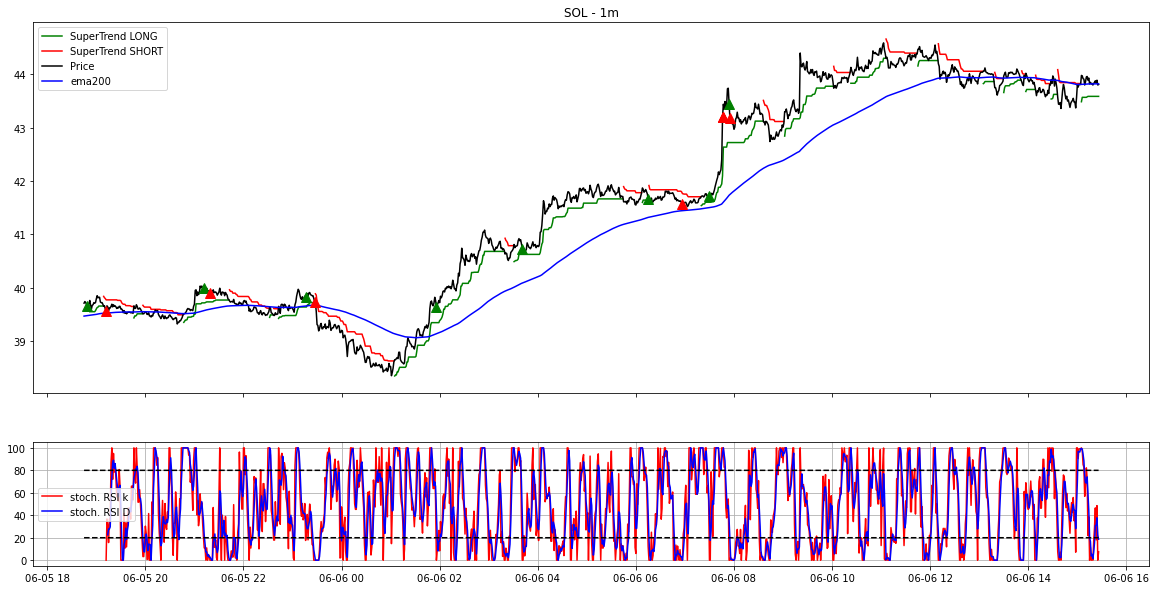

In [69]:
plot_supatrend_stoch(df, [ppr.p[14], ppr.q[14]])

## Build Signals and live trading on Binance Testnet